<a href="https://colab.research.google.com/github/geoffcorvera/deeplearning-spring2021/blob/hw4/Grad_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import numpy as np 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions

import matplotlib.pyplot as plt 

# Parameters
We load the VGG16 model (pretrained on the ImageNet dataset). The last convolutional layer in this model is named "block5_conv3" (run model.summary() to view layers of network). We define store the dimensions that input images need to be (224x224), and the path to our test files.

In [24]:
model = VGG16(weights='imagenet')
last_conv_name = 'block5_conv3'

target_size = (224,224)
img_dir = r'/content/drive/MyDrive/Spring2021/Deep Learning & Computer Vision/prog4_data'
filenames = ['gc1.jpg', 'gc2.jpg', 'gc3.jpg', 'gc4.jpg', 'gc5.jpg']

In [25]:
def preprocess_image(ipath, isize):
    # load_image returns a PIL image resized to (224,224)
    img = keras.preprocessing.image.load_img(ipath, target_size=isize)
    # convert to 3D numpy array
    im_arr = keras.preprocessing.image.img_to_array(img)
    # preprocess as per VGG16
    im_arr = preprocess_input(im_arr)
    # add dim to turn into batch of size 1
    im_arr = np.expand_dims(img, axis=0)
    return im_arr

# Display Top 3 Predictions
We run model.predict() on a test image and use the decode_predictions function from the VGG16 module to display the top three predicted classes the model made.

In [26]:
def top_preds_desc(preds):
  s = f"Top {len(preds)} predictions:"
  for (i, (desc, score)) in enumerate(preds):
    s += f"\n{i+1}) {desc} (Score: {score:.4f})"
  return s

def get_top3_preds(preds):
  decoded = decode_predictions(preds, top=3)[0]
  return [tuple(pred[1:]) for pred in decoded]

In [27]:
preprocessed_imgs = [preprocess_image(f'{img_dir}/{fname}', target_size) for fname in filenames]
top3_preds = [get_top3_preds(model.predict(img)) for img in preprocessed_imgs]

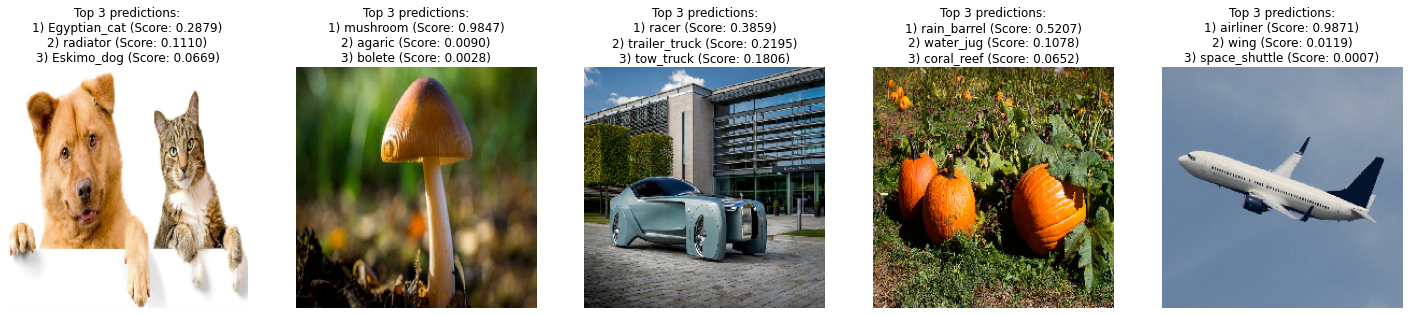

In [28]:
n_images = len(preprocessed_imgs)
fig, axs = plt.subplots(ncols=n_images, figsize=(25,20))
for (ax, img, top3) in zip(fig.axes, preprocessed_imgs, top3_preds):
  ax.axis('off')
  ax.set_title(top_preds_desc(top3))
  ax.imshow(img[0])

plt.show()

# Create Heatmaps
We use gradient weighted class activation maps to create heatmaps that highlight the portions of the input image that contributed the most to a specified classification.

The generated heatmaps will be the same size as the filters in the final convolutional layer (14 x 14 for VGG16). The Grad-CAM heatmaps are resized to input image size. They 

TODO: use original images (not preprocessed) for final superimposed image.

In [29]:
# From Stack Overflow post: https://stackoverflow.com/questions/58322147/how-to-generate-cnn-heatmaps-using-built-in-keras-in-tf2-0-tf-keras
def grad_cam(image, model, last_conv_name, score_to_match=None):
  last_layer = model.get_layer(last_conv_name)
  # Create a multi-output model that maps input image to activations of the 
  # last conv layer & the output predictions
  heatmap_model = keras.models.Model(
      inputs=[model.inputs],
      outputs=[last_layer.output, model.output]
  )

  # Calc the gradient of the top predicted class for input image wrt last conv activations
  with tf.GradientTape() as gtape:
    conv_output, predictions = heatmap_model(image)

    if (score_to_match == None):
      p_index = tf.argmax(predictions[0])
    else:
      p_index = tf.where(tf.equal(predictions[0], tf.constant(score_to_match)))
      p_index = p_index.numpy().squeeze()
    
    class_channel = predictions[:, p_index]

    # Gradient of top-1 prediction neuron wrt output of feature map of last conv layer
    grads = gtape.gradient(class_channel, conv_output)
    # Each element in this vector is the mean intensity of the gradient over a specific feature map channel
    importance_weights = tf.reduce_mean(grads, axis=(0,1,2))

  # Calc the weighted sum of each feature map channel (weighted by importance_weights)
  # wrt the top predicted class
  activations = conv_output[0]
  heatmap = activations @ importance_weights[..., tf.newaxis]
  heatmap = tf.squeeze(heatmap)
  # Apply ReLU and scale values for display
  heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
  return heatmap.numpy()

In [30]:
all_heatmaps = []
for img, top3 in zip(preprocessed_imgs, top3_preds):
  all_heatmaps.append([(desc, grad_cam(img, model, last_conv_name, score)) for desc, score in top3])

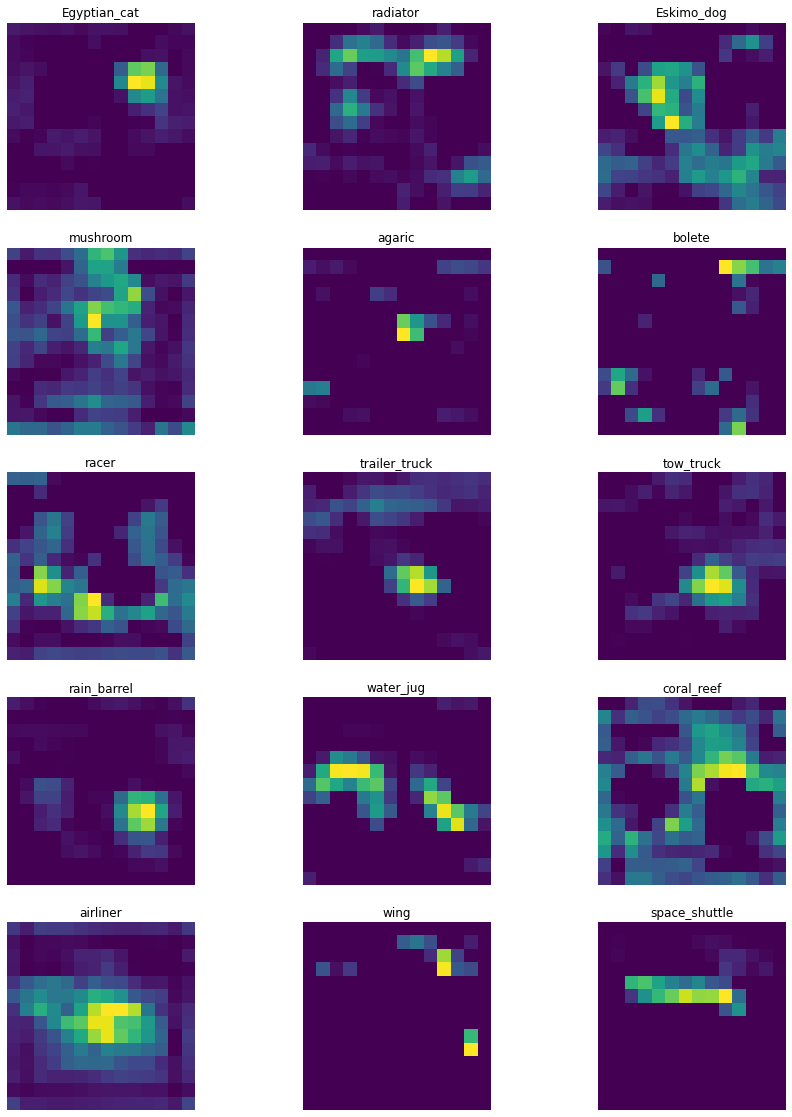

In [31]:
fig, axs = plt.subplots(n_images, 3, figsize=(15,20))
for row, maps in zip(axs, all_heatmaps):
  for ax, (desc, map) in zip(row, maps):
    ax.set_title(desc)
    ax.axis('off')
    ax.imshow(map)

plt.show()

# Superimpose Heatmaps & Images

In [32]:
def resize_and_rescale_intensities(matrix, shape):
  # Add 'batch' and 'channels' dimensions
  res = matrix[tf.newaxis, ..., tf.newaxis]
  res = tf.image.resize(res, (shape[0], shape[1])).numpy()
  res = res.squeeze()
  return np.uint8(255 * res)

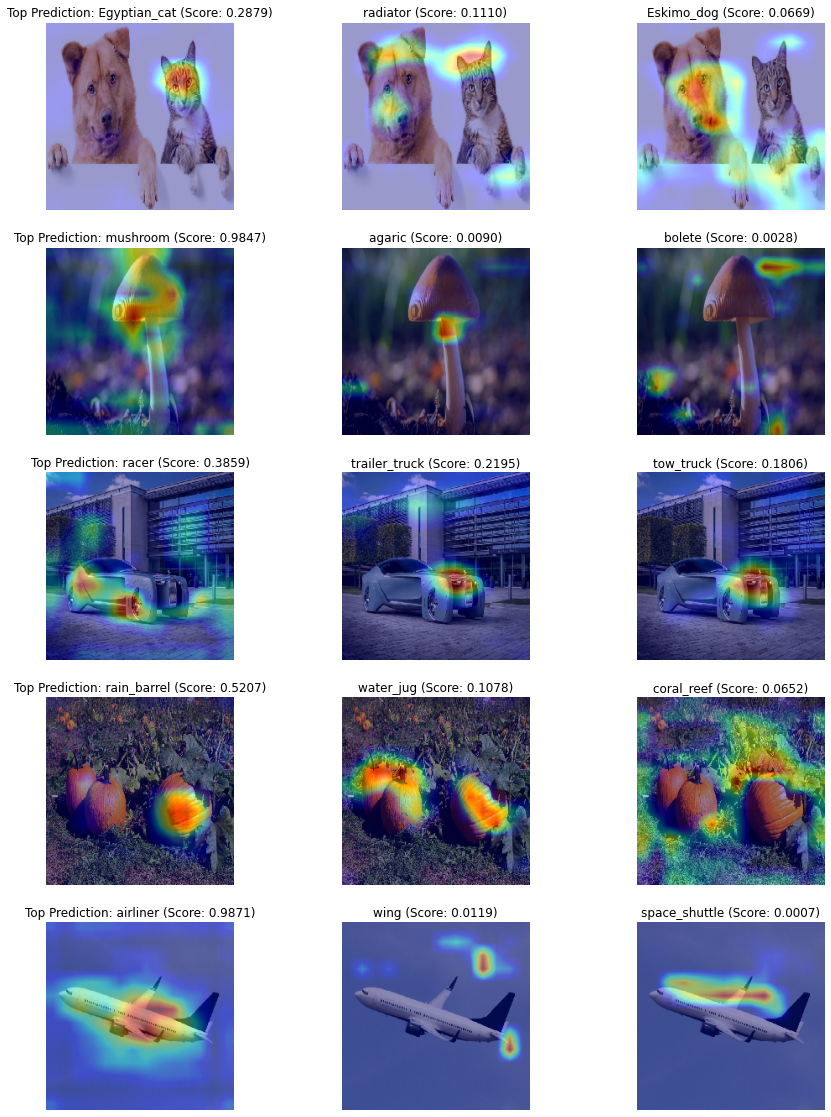

In [33]:
fig, axs = plt.subplots(nrows=n_images, ncols=3, figsize=(15,20))

assert axs.shape[0] == len(preprocessed_imgs)
for (row, img, top3) in zip(axs, preprocessed_imgs, top3_preds):
  for (i, ax, (desc, score)) in zip(range(3), row, top3):
    heatmap = grad_cam(img, model, last_conv_name, score)
    heatmap = resize_and_rescale_intensities(heatmap, img.shape[1:])
    title = f"Top Prediction: {desc}" if (i == 0) else desc
    title += f" (Score: {score:.4f})"
    
    ax.imshow(img.squeeze())
    ax.imshow(heatmap, cmap='jet', alpha=0.4)
    ax.axis('off')
    ax.set_title(title)

plt.show()